In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#df = pd.read_csv('./ecog_train_with_labels.csv')

In [3]:
import feather

In [4]:
#feather.write_dataframe(df, './ecog_train_with_labels')

In [5]:
df = feather.read_dataframe('./ecog_train_with_labels')

In [6]:
patients = df.PatientID.unique()

In [7]:
patient_df = df[df.PatientID==patients[0]]

In [8]:
import nitime.timeseries as nits

In [9]:
def read_data(df):
    ts = nits.TimeSeries(df[['Electrode_%s'%E for E in range(1, 65)]].T, 
                     sampling_rate=1000, time_unit='ms')
    for chan in range(ts.shape[0]):
        if np.all(ts.data[chan] == -999999):
            ts.data[chan] = np.nan
    return ts

In [10]:
ts_stim3 = read_data(patient_df[patient_df.Stimulus_ID==3])

In [11]:
def plot_ts(ts, idx=None):
    fig, ax = plt.subplots(1)
    if idx is not None:
        ax.plot(ts.time/ts.time._conversion_factor, ts.data[idx, :].T)
    else: 
        ax.plot(ts.time/ts.time._conversion_factor, ts.data.T)
    ax.set_xlabel("Time[%s]"%ts.time_unit)

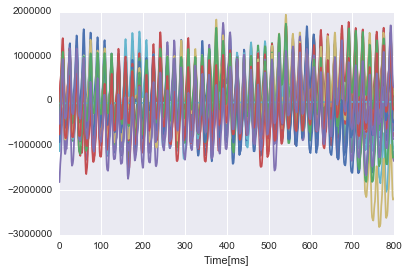

In [12]:
plot_ts(ts_stim3)

In [13]:
def matshow_ts(ts):
    fig, ax = plt.subplots(1)
    ax.matshow(ts.data, cmap='viridis')
    ax.set_xlabel('Time[%s]'%ts.time_unit)
    fig.set_size_inches([20, 10])

/Users/arokem/anaconda/lib/python3.5/site-packages/numpy-1.11.0b2-py3.5-macosx-10.5-x86_64.egg/numpy/ma/core.py:3113: FutureWarning: Currently, slicing will try to return a view of the data, but will return a copy of the mask. In the future, it will try to return both as views.
  FutureWarning


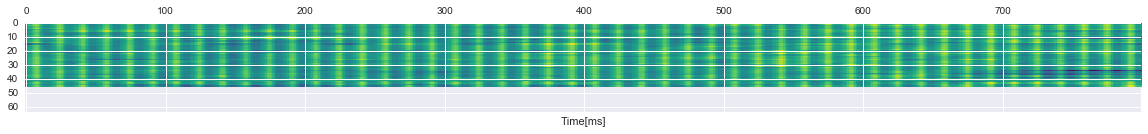

In [14]:
matshow_ts(ts_stim3)

In [15]:
import nitime.analysis as nita

In [16]:
ts = read_data(patient_df)

In [17]:
SA = nita.SpectralAnalyzer(ts, method={'NFFT':1024})

(0, 130)

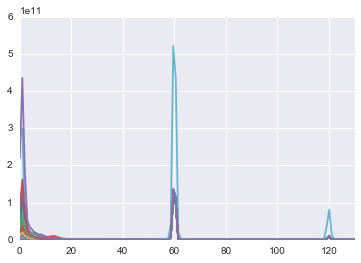

In [18]:
plt.plot(SA.psd[0], SA.psd[1].T)
plt.xlim([0, 130])

In [19]:
ub = 40
lb = None

In [20]:
def filter_patient_data(df, patient_id, ub, lb=None):
    """ 
    ub : upper bound of the low-pass
    lb : lower bound of the high-pass
    """
    patient_df = df[df.PatientID==patient]
    ts = read_data(patient_df)
    FA_low = nita.FilterAnalyzer(ts, ub=ub)
    result = FA_low.fir.data
    if lb is not None:
        FA_high = nita.FilterAnalyzer(ts, lb=lb)
        result = result + FA_high.fir.data
    new_df = patient_df.copy()
    for chan in range(ts.shape[0]):
        new_df['Electrode_%s'%(chan+1)] = result[chan]
    return new_df

In [21]:
dfs = []
for patient in patients:
    dfs.append(filter_patient_data(df, patient, ub, lb))

In [22]:
patients

array(['p1', 'p2', 'p3', 'p4'], dtype=object)

In [23]:
filt_df = pd.concat(dfs)

In [24]:
patient_df_filt = filt_df[filt_df.PatientID==patients[0]]
ts_stim3_filt = read_data(patient_df_filt[patient_df_filt.Stimulus_ID==3])

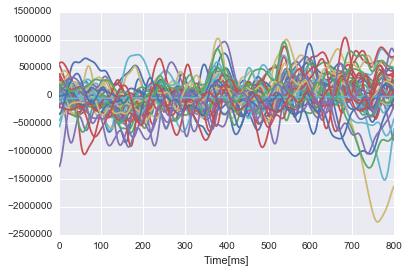

In [25]:
plot_ts(ts_stim3_filt)

/Users/arokem/anaconda/lib/python3.5/site-packages/numpy-1.11.0b2-py3.5-macosx-10.5-x86_64.egg/numpy/ma/core.py:3113: FutureWarning: Currently, slicing will try to return a view of the data, but will return a copy of the mask. In the future, it will try to return both as views.
  FutureWarning


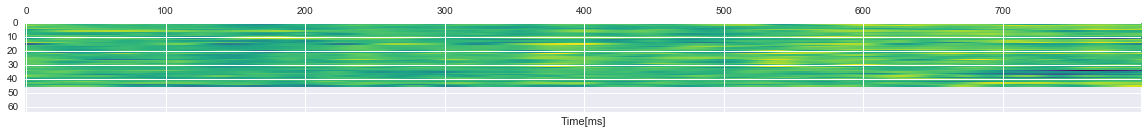

In [26]:
matshow_ts(ts_stim3_filt)

In [27]:
SA_filt = nita.SpectralAnalyzer(read_data(patient_df_filt), method={'NFFT':1024})

(0, 130)

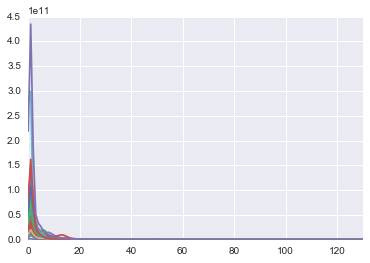

In [28]:
plt.plot(SA_filt.psd[0], SA_filt.psd[1].T)
plt.xlim([0, 130])

In [29]:
feather.write_dataframe(df, './ecog_train_with_labels_low_pass%s'%ub)